In [131]:
# Add scripts to path and fix working directory
import sys
import os
from pathlib import Path

# Set project root explicitly
project_root = Path(__file__).parent.parent.parent if '__file__' in locals() else Path("/home/Plutonium/Documents/BioinfoMidterm")

os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("sea_jpt_cn")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
ML = cfg.ML
POPULATIONS = cfg.POPULATIONS

# Import other modules
from utils import (
    vcf_to_numeric_matrix,
    add_population_labels,
    ensure_dir,
    run_bcftools_command,
    variants_to_bed_file,
)
from ml_training import (
    load_ml_data,
    train_random_forest,
    train_xgboost,
    train_logistic_regression,
    evaluate_model,
    cross_validate_model,
    get_feature_importances,
    train_on_top_features,
    save_model,
    run_full_pipeline,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check TabPFN availability
try:
    from tabpfn import TabPFNClassifier
    TABPFN_AVAILABLE = True
    print("✓ TabPFN is available")
except ImportError:
    TABPFN_AVAILABLE = False
    print("✗ TabPFN not available (install with: pip install tabpfn)")

TABPFN_AVAILABLE = False
# Configuration
print("\nML Configuration:")
print(f"  Test size: {ML.TEST_SIZE}")
print(f"  Random state: {ML.RANDOM_STATE}")
print(f"  RF estimators: {ML.RF_N_ESTIMATORS}")
print(f"  XGB estimators: {ML.XGB_N_ESTIMATORS}")
print(f"  Top N features: {ML.TOP_N_FEATURES}")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
✓ TabPFN is available

ML Configuration:
  Test size: 0.2
  Random state: 42
  RF estimators: 200
  XGB estimators: 200
  Top N features: 25


In [132]:
# Check if all ML results already exist - skip training if so
output_dir = PATHS.ML_MODELS_DIR

# Define required output files for this notebook
REQUIRED_OUTPUTS = [
    output_dir / "model_comparison.csv",
    output_dir / "feature_importances.csv",
    output_dir / "feature_size_results.csv",
    output_dir / "fst_only_top50_ml_data.csv",
    output_dir / "random_forest_full.pkl",
]

# Check if all outputs exist
existing_outputs = [f for f in REQUIRED_OUTPUTS if f.exists()]
missing_outputs = [f for f in REQUIRED_OUTPUTS if not f.exists()]

SKIP_TRAINING = len(missing_outputs) == 0

print("="*70)
print("04a FST-ONLY ML TRAINING - OUTPUT CHECK")
print("="*70)

if SKIP_TRAINING:
    print("\n✓ All required outputs already exist!")
    print("  Training will be SKIPPED. Delete outputs to re-run.")
    print(f"\nExisting outputs ({len(existing_outputs)}):")
    for f in existing_outputs:
        print(f"  ✓ {f.name}")
else:
    print(f"\n✗ Missing outputs ({len(missing_outputs)}):")
    for f in missing_outputs:
        print(f"  ✗ {f.name}")
    print("\n→ Training will proceed.")
    if existing_outputs:
        print(f"\nExisting outputs ({len(existing_outputs)}):")
        for f in existing_outputs:
            print(f"  ✓ {f.name}")

04a FST-ONLY ML TRAINING - OUTPUT CHECK

✗ Missing outputs (1):
  ✗ fst_only_top50_ml_data.csv

→ Training will proceed.

Existing outputs (4):
  ✓ model_comparison.csv
  ✓ feature_importances.csv
  ✓ feature_size_results.csv
  ✓ random_forest_full.pkl


## Step 1: Prepare ML Data

Check if ML data exists. If not, run VCF conversion pipeline to create it.

In [133]:
# Check if ML data exists
import os

ML_DATA_PATH = str(PATHS.ML_DATA)

if os.path.exists(ML_DATA_PATH):
    print(f"✓ ML data exists: {ML_DATA_PATH}")
    NEED_VCF_CONVERSION = False
else:
    print("✗ ML data not found. Will run VCF conversion steps.")
    NEED_VCF_CONVERSION = True

✓ ML data exists: 1000genomes/vcf_sea_jpt_cn/vcf_numeric_transposed_with_population.csv


## Step 1a: VCF to Numeric Conversion (if needed)

This section converts VCF data to a numeric genotype matrix suitable for ML.

**Pipeline:**
1. Extract selected SNPs from VCF using BED coordinates
2. Filter to biallelic SNPs only
3. Convert genotypes to numeric (0/1/2)
4. Transpose so samples are rows
5. Add population labels

In [134]:
# Step 1: Extract SNPs from VCF using BED file
if NEED_VCF_CONVERSION:
    from utils import run_bcftools_command, variants_to_bed_file
    
    # Paths
    TOP_SNPS_FILE = str(PATHS.TOP_SNPS_FILE)
    TOP_SNPS_BED = str(PATHS.TOP_SNPS_BED)
    VCF_FILE = str(PATHS.VCF_FILE)
    FILTERED_VCF = str(PATHS.VCF_DIR / "filtered.vcf.gz")
    SAMPLES_LIST = str(PATHS.EAS_SAMPLES_LIST)
    
    # Convert SNP IDs to BED format (if not exists)
    if not os.path.exists(TOP_SNPS_BED):
        print("Converting SNP IDs to BED format...")
        variants_to_bed_file(TOP_SNPS_FILE, TOP_SNPS_BED)
    else:
        print(f"✓ BED file exists: {TOP_SNPS_BED}")
    
    # Extract SNPs from VCF
    print("\nExtracting SNPs from VCF...")
    run_bcftools_command([
        "view",
        "-S", SAMPLES_LIST,
        "-R", TOP_SNPS_BED,
        "-Oz",
        "-o", FILTERED_VCF,
        VCF_FILE
    ])
    print(f"✓ Created filtered VCF: {FILTERED_VCF}")
else:
    print("Skipping VCF extraction - ML data already exists.")

Skipping VCF extraction - ML data already exists.


In [135]:
# Step 2: Filter to biallelic SNPs only
if NEED_VCF_CONVERSION:
    FILTERED_VCF = str(PATHS.VCF_DIR / "filtered.vcf.gz")
    SNPS_ONLY_VCF = str(PATHS.VCF_DIR / "filtered_snps_only.vcf")
    SNPS_FINAL_VCF = str(PATHS.VCF_DIR / "filtered_snps_only_final.vcf")
    
    print("Filtering to biallelic SNPs only...")
    
    # Filter ALT to single nucleotide
    run_bcftools_command([
        "view",
        "-i", 'ALT ~ "^[ATGC]$"',
        "-o", SNPS_ONLY_VCF,
        FILTERED_VCF
    ])
    
    # Filter REF to single nucleotide
    run_bcftools_command([
        "view",
        "-i", 'REF ~ "^[ATGC]$"',
        "-o", SNPS_FINAL_VCF,
        SNPS_ONLY_VCF
    ])
    
    print(f"✓ Created biallelic SNP VCF: {SNPS_FINAL_VCF}")
else:
    print("Skipping SNP filtering - ML data already exists.")

Skipping SNP filtering - ML data already exists.


In [136]:
# Step 3: Clean VCF (remove ## header lines) and convert to numeric matrix
if NEED_VCF_CONVERSION:
    SNPS_FINAL_VCF = str(PATHS.VCF_DIR / "filtered_snps_only_final.vcf")
    CLEAN_VCF = str(PATHS.VCF_DIR / "snps_only_clean.vcf")
    NUMERIC_CSV = str(PATHS.VCF_DIR / "vcf_numeric_transposed.csv")
    
    # Remove ## meta lines, keep #CHROM header and data
    print("Cleaning VCF headers...")
    with open(SNPS_FINAL_VCF, 'r') as fin, open(CLEAN_VCF, 'w') as fout:
        for line in fin:
            if not line.startswith('##'):
                fout.write(line)
    print(f"✓ Created clean VCF: {CLEAN_VCF}")
    
    # Convert to numeric matrix using utility function
    print("\nConverting VCF to numeric matrix...")
    numeric_df = vcf_to_numeric_matrix(CLEAN_VCF, NUMERIC_CSV, verbose=True)
else:
    print("Skipping VCF cleaning - ML data already exists.")

Skipping VCF cleaning - ML data already exists.


In [137]:
# Step 4: Add population labels
if NEED_VCF_CONVERSION:
    NUMERIC_CSV = str(PATHS.VCF_DIR / "vcf_numeric_transposed.csv")
    POPULATION_CSV = str(PATHS.EAS_SAMPLES_CSV)
    ML_DATA_OUTPUT = str(PATHS.ML_DATA)
    
    print("Adding population labels...")
    final_df = add_population_labels(NUMERIC_CSV, POPULATION_CSV, ML_DATA_OUTPUT, verbose=True)
    
    print(f"\n✓ ML data created successfully!")
    print(f"  Output: {ML_DATA_OUTPUT}")
    print(f"  Shape: {final_df.shape}")
    print(f"  Populations: {final_df['pop'].value_counts().to_dict()}")
    
    # Update path for downstream steps
    ML_DATA_PATH = ML_DATA_OUTPUT
else:
    print("Skipping population labeling - ML data already exists.")

Skipping population labeling - ML data already exists.


## Step 1b: Load ML Data

Load the prepared numeric matrix with population labels.

In [138]:
# Load ML data (needed even if skipping training for summary)
X, y, feature_names = load_ml_data(
    ML_DATA_PATH,
    target_column="pop",
    verbose=True,
)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())

# Encode labels (needed for loading saved results)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Classes: {le.classes_}")

Loading data from: 1000genomes/vcf_sea_jpt_cn/vcf_numeric_transposed_with_population.csv
  Samples: 504
  Features: 2518
  Classes: 3 ({'CN': 208, 'SEA': 192, 'JPT': 104})

Feature matrix shape: (504, 2518)
Target distribution:
pop
CN     208
SEA    192
JPT    104
Name: count, dtype: int64
Classes: ['CN' 'JPT' 'SEA']


In [139]:
# Split data (needed for training)
if not SKIP_TRAINING:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=ML.TEST_SIZE,
        stratify=y,
        random_state=ML.RANDOM_STATE,
    )

    y_train_encoded = le.transform(y_train)
    y_test_encoded = le.transform(y_test)

    print(f"Train set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
else:
    print("⏭️ Skipping data split - using cached results")

Train set: 403 samples
Test set: 101 samples


## Step 2: Train Random Forest

In [140]:
# Train Random Forest
if not SKIP_TRAINING:
    rf = train_random_forest(
        X_train, y_train,
        n_estimators=ML.RF_N_ESTIMATORS,
        verbose=True,
    )
else:
    print("⏭️ Skipping Random Forest training - using cached results")


Training Random Forest...
  n_estimators: 200
  max_depth: None


  Training complete!


In [141]:
# Evaluate Random Forest
if not SKIP_TRAINING:
    rf_results = evaluate_model(rf, X_test, y_test, "Random Forest", verbose=True)
else:
    print("⏭️ Skipping RF evaluation - using cached results")


Random Forest EVALUATION
Accuracy: 0.9802
F1 (macro): 0.9833
F1 (weighted): 0.9802

Classification Report:
              precision    recall  f1-score   support

          CN       1.00      0.95      0.98        42
         JPT       1.00      1.00      1.00        21
         SEA       0.95      1.00      0.97        38

    accuracy                           0.98       101
   macro avg       0.98      0.98      0.98       101
weighted avg       0.98      0.98      0.98       101



In [142]:
# Cross-validation
if not SKIP_TRAINING:
    from sklearn.ensemble import RandomForestClassifier

    rf_cv = cross_validate_model(
        RandomForestClassifier(n_estimators=ML.RF_N_ESTIMATORS, random_state=ML.RANDOM_STATE),
        X, y,
        cv=ML.CV_FOLDS,
        model_name="Random Forest",
    )
else:
    print("⏭️ Skipping RF cross-validation - using cached results")


Cross-validating Random Forest (5-fold)...
  CV Accuracy: 0.9583 (+/- 0.0556)


## Step 3: Train XGBoost

In [143]:
# Train XGBoost
if not SKIP_TRAINING:
    try:
        xgb_clf = train_xgboost(
            X_train, y_train_encoded,
            n_estimators=ML.XGB_N_ESTIMATORS,
            max_depth=ML.XGB_MAX_DEPTH,
            learning_rate=ML.XGB_LEARNING_RATE,
            verbose=True,
        )
        
        # Evaluate
        xgb_results = evaluate_model(xgb_clf, X_test, y_test_encoded, "XGBoost", verbose=True)
    except ImportError as e:
        print(f"XGBoost not available: {e}")
        xgb_clf = None
else:
    xgb_clf = None
    print("⏭️ Skipping XGBoost training - using cached results")


Training XGBoost...
  n_estimators: 200
  max_depth: 6
  learning_rate: 0.1


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [02:05:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Training complete!

XGBoost EVALUATION
Accuracy: 0.9703
F1 (macro): 0.9713
F1 (weighted): 0.9703

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       1.00      0.95      0.98        21
           2       0.95      1.00      0.97        38

    accuracy                           0.97       101
   macro avg       0.98      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101



## Step 4: Train Logistic Regression

In [144]:
# Train Logistic Regression
if not SKIP_TRAINING:
    lr = train_logistic_regression(
        X_train, y_train,
        max_iter=ML.LR_MAX_ITER,
        verbose=True,
    )

    # Evaluate
    lr_results = evaluate_model(lr, X_test, y_test, "Logistic Regression", verbose=True)
else:
    print("⏭️ Skipping Logistic Regression training - using cached results")


Training Logistic Regression...
  max_iter: 1000
  solver: lbfgs


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Training complete!

Logistic Regression EVALUATION
Accuracy: 1.0000
F1 (macro): 1.0000
F1 (weighted): 1.0000

Classification Report:
              precision    recall  f1-score   support

          CN       1.00      1.00      1.00        42
         JPT       1.00      1.00      1.00        21
         SEA       1.00      1.00      1.00        38

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



## Step 5: Compare Models

In [145]:
# Collect results or load from cache
if not SKIP_TRAINING:
    results = {
        "Random Forest": rf_results,
        "Logistic Regression": lr_results,
    }
    if xgb_clf is not None:
        results["XGBoost"] = xgb_results

    # Comparison table
    comparison_df = pd.DataFrame({
        "Model": results.keys(),
        "Accuracy": [r["accuracy"] for r in results.values()],
        "F1 (macro)": [r["f1_macro"] for r in results.values()],
        "F1 (weighted)": [r["f1_weighted"] for r in results.values()],
    })

    print("Model Comparison:")
    display(comparison_df)
else:
    # Load cached results
    comparison_df = pd.read_csv(output_dir / "model_comparison.csv")
    print("📊 Loaded cached model comparison:")
    display(comparison_df)

Model Comparison:


,Model,Accuracy,F1 (macro),F1 (weighted)
0,Random Forest,0.980198,0.983323,0.980210
1,Logistic Regression,1.000000,1.000000,1.000000
2,XGBoost,0.970297,0.971275,0.970251


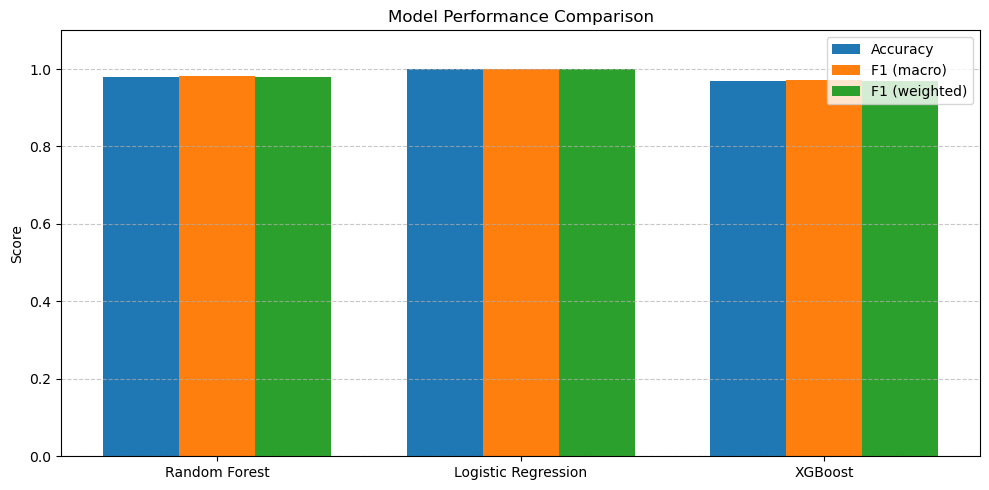

In [146]:
# Visualize comparison
if not SKIP_TRAINING:
    fig, ax = plt.subplots(figsize=(10, 5))

    x = np.arange(len(comparison_df))
    width = 0.25

    ax.bar(x - width, comparison_df["Accuracy"], width, label="Accuracy")
    ax.bar(x, comparison_df["F1 (macro)"], width, label="F1 (macro)")
    ax.bar(x + width, comparison_df["F1 (weighted)"], width, label="F1 (weighted)")

    ax.set_ylabel("Score")
    ax.set_title("Model Performance Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df["Model"])
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
else:
    print("⏭️ Skipping visualization - using cached results")

## Step 6: Confusion Matrices

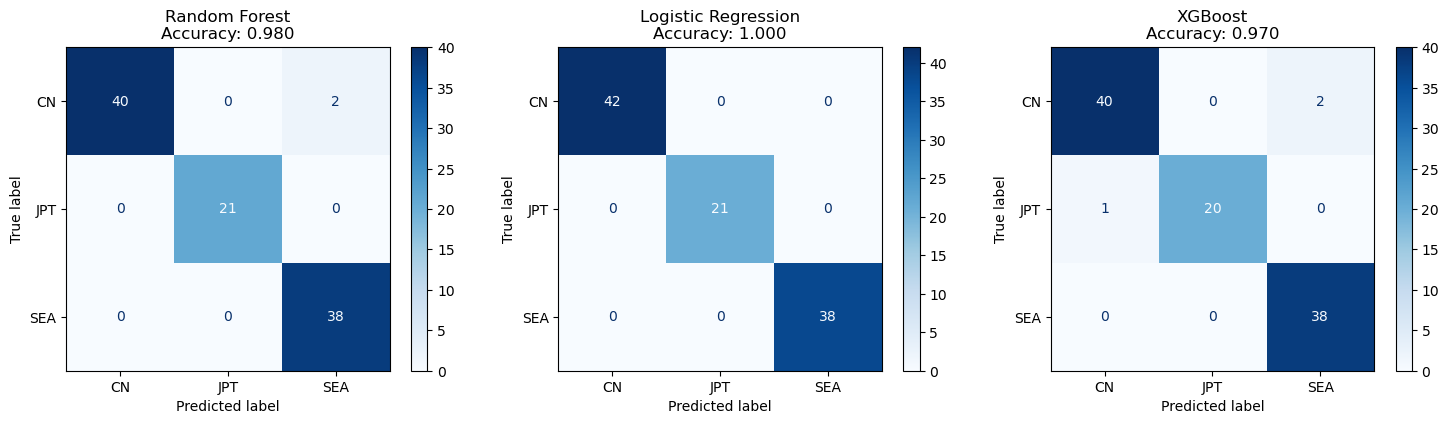

In [147]:
# Plot confusion matrices
if not SKIP_TRAINING:
    fig, axes = plt.subplots(1, len(results), figsize=(5*len(results), 4))

    if len(results) == 1:
        axes = [axes]

    for ax, (name, result) in zip(axes, results.items()):
        ConfusionMatrixDisplay(
            result["confusion_matrix"],
            display_labels=le.classes_,
        ).plot(ax=ax, cmap="Blues")
        ax.set_title(f"{name}\nAccuracy: {result['accuracy']:.3f}")

    plt.tight_layout()
    plt.show()
else:
    print("⏭️ Skipping confusion matrix plots - using cached results")

In [148]:
# Get feature importances from Random Forest (or load from cache)
if not SKIP_TRAINING:
    rf_importance = get_feature_importances(
        rf, feature_names,
        top_n=ML.TOP_N_FEATURES,
        verbose=True,
    )
else:
    rf_importance = pd.read_csv(output_dir / "feature_importances.csv")
    print(f"📊 Loaded cached feature importances: {len(rf_importance)} features")


Top 25 Features by Importance:
  1:12387655: 0.011238
  3:152553769: 0.010802
  4:17813761: 0.009931
  19:54792079: 0.008571
  14:96938945: 0.008308
  3:86028382: 0.008068
  6:82912256: 0.006744
  9:37486004: 0.006534
  9:98231346: 0.006479
  16:33974960: 0.005293
  21:38533017: 0.004946
  5:41181491: 0.004766
  10:134188783: 0.004662
  1:22315762: 0.004484
  12:4388084: 0.004472
  16:67913222: 0.004432
  6:152588967: 0.004400
  14:96755874: 0.004270
  10:31138896: 0.004136
  18:18518431: 0.003687
  1:33070778: 0.003634
  11:112053732: 0.003580
  1:102457870: 0.003393
  9:133578385: 0.003243
  6:170619277: 0.003167


## Step 8b: Test Multiple Feature Set Sizes (5 to 50 SNPs)

Evaluate model performance across different numbers of top SNPs to find the optimal feature set size.

In [149]:
# Define feature set sizes to test (5 to 50, increment of 5)
if not SKIP_TRAINING:
    feature_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

    # Get ordered list of top features from RF importance
    top_features_ordered = rf_importance['feature'].tolist()

    # Limit to available features
    max_features = min(50, len(top_features_ordered))
    feature_sizes = [s for s in feature_sizes if s <= max_features]

    print(f"Testing feature set sizes: {feature_sizes}")
    print(f"Total available features: {len(top_features_ordered)}")
else:
    print("⏭️ Skipping feature size definition - using cached results")

Testing feature set sizes: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Total available features: 2518


In [150]:
# Test each feature set size with multiple classifiers
if not SKIP_TRAINING:
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    from sklearn.preprocessing import StandardScaler

    # Select classifiers to test
    test_classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                      random_state=42, n_jobs=-1, verbosity=0),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, 
                                                   multi_class='multinomial', n_jobs=-1),
        'SVM (RBF)': SVC(kernel='rbf', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scaler = StandardScaler()

    feature_size_results = []

    for n_features in feature_sizes:
        print(f"\n{'='*60}")
        print(f"Testing with TOP {n_features} SNPs")
        print(f"{'='*60}")
        
        # Get top N features
        top_n_features = top_features_ordered[:n_features]
        X_reduced = X[top_n_features]
        X_reduced_scaled = scaler.fit_transform(X_reduced)
        
        for clf_name, clf in test_classifiers.items():
            # Clone classifier for fresh training
            clf_clone = clf.__class__(**clf.get_params())
            
            # Use scaled data for SVM and LR
            if 'SVM' in clf_name or 'Logistic' in clf_name:
                X_use = X_reduced_scaled
            else:
                X_use = X_reduced.values
            
            # Use encoded labels for XGBoost
            if 'XGBoost' in clf_name:
                y_use = y_encoded
            else:
                y_use = y
            
            try:
                cv_scores = cross_val_score(clf_clone, X_use, y_use, cv=cv, scoring='accuracy')
                feature_size_results.append({
                    'N_Features': n_features,
                    'Model': clf_name,
                    'Accuracy_Mean': cv_scores.mean(),
                    'Accuracy_Std': cv_scores.std()
                })
                print(f"  {clf_name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            except Exception as e:
                print(f"  {clf_name}: Error - {e}")
                feature_size_results.append({
                    'N_Features': n_features,
                    'Model': clf_name,
                    'Accuracy_Mean': np.nan,
                    'Accuracy_Std': np.nan
                })

    feature_size_df = pd.DataFrame(feature_size_results)
    print("\n" + "="*60)
    print("Feature size testing complete!")
else:
    # Load cached feature size results
    feature_size_df = pd.read_csv(output_dir / 'feature_size_results.csv')
    print("⏭️ Loaded cached feature size results")


Testing with TOP 5 SNPs
  Random Forest: 0.6825 ± 0.0145
  XGBoost: 0.6845 ± 0.0190
  Logistic Regression: 0.6884 ± 0.0222
  SVM (RBF): 0.6786 ± 0.0175


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.6765 ± 0.0230

Testing with TOP 10 SNPs
  Random Forest: 0.7759 ± 0.0395
  XGBoost: 0.7619 ± 0.0318
  Logistic Regression: 0.7619 ± 0.0213
  SVM (RBF): 0.7858 ± 0.0311


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.7659 ± 0.0371

Testing with TOP 15 SNPs
  Random Forest: 0.8135 ± 0.0381
  XGBoost: 0.8095 ± 0.0394
  Logistic Regression: 0.8016 ± 0.0476
  SVM (RBF): 0.8055 ± 0.0271


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.7976 ± 0.0420

Testing with TOP 20 SNPs
  Random Forest: 0.8313 ± 0.0360
  XGBoost: 0.8234 ± 0.0389
  Logistic Regression: 0.8254 ± 0.0253
  SVM (RBF): 0.8333 ± 0.0254


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8055 ± 0.0349

Testing with TOP 25 SNPs
  Random Forest: 0.8690 ± 0.0390
  XGBoost: 0.8750 ± 0.0401
  Logistic Regression: 0.8730 ± 0.0346


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  SVM (RBF): 0.8809 ± 0.0421
  Gradient Boosting: 0.8511 ± 0.0384

Testing with TOP 30 SNPs
  Random Forest: 0.8968 ± 0.0371
  XGBoost: 0.8928 ± 0.0313
  Logistic Regression: 0.8928 ± 0.0233
  SVM (RBF): 0.9146 ± 0.0314


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8908 ± 0.0346

Testing with TOP 35 SNPs
  Random Forest: 0.8968 ± 0.0402
  XGBoost: 0.8987 ± 0.0300
  Logistic Regression: 0.9008 ± 0.0259
  SVM (RBF): 0.9106 ± 0.0329


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8967 ± 0.0367

Testing with TOP 40 SNPs
  Random Forest: 0.9107 ± 0.0234
  XGBoost: 0.9086 ± 0.0307
  Logistic Regression: 0.9107 ± 0.0219
  SVM (RBF): 0.9167 ± 0.0270


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8888 ± 0.0258

Testing with TOP 45 SNPs
  Random Forest: 0.9107 ± 0.0109
  XGBoost: 0.9067 ± 0.0226
  Logistic Regression: 0.9166 ± 0.0176
  SVM (RBF): 0.9246 ± 0.0240


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8987 ± 0.0287

Testing with TOP 50 SNPs
  Random Forest: 0.9345 ± 0.0050
  XGBoost: 0.9047 ± 0.0207
  Logistic Regression: 0.9266 ± 0.0203
  SVM (RBF): 0.9445 ± 0.0204


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8968 ± 0.0255

Feature size testing complete!


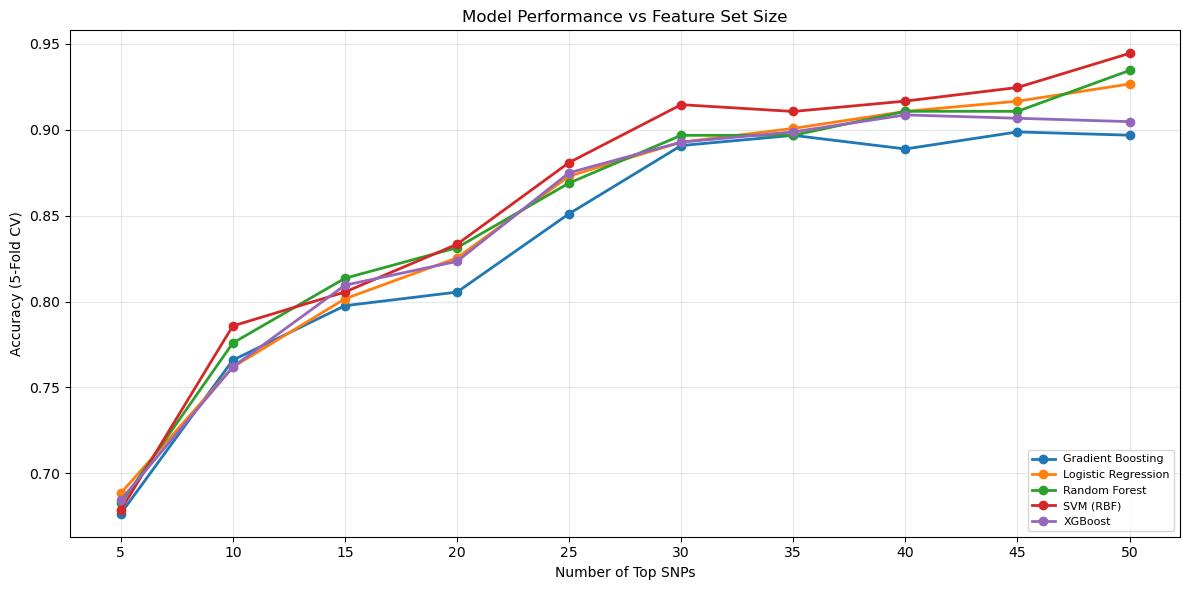

In [151]:
# Pivot table for visualization
pivot_df = feature_size_df.pivot(index='Model', columns='N_Features', values='Accuracy_Mean')

# Plot 1: Line plot - Accuracy vs Feature Size by Model
fig, ax = plt.subplots(figsize=(12, 6))
for model in pivot_df.index:
    ax.plot(feature_sizes, pivot_df.loc[model].values, 'o-', label=model, linewidth=2, markersize=6)
ax.set_xlabel('Number of Top SNPs')
ax.set_ylabel('Accuracy (5-Fold CV)')
ax.set_title('Model Performance vs Feature Set Size')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xticks(feature_sizes)
plt.tight_layout()
plt.savefig(str(output_dir / 'feature_size_line_plot.png'), dpi=150, bbox_inches='tight')
plt.show()

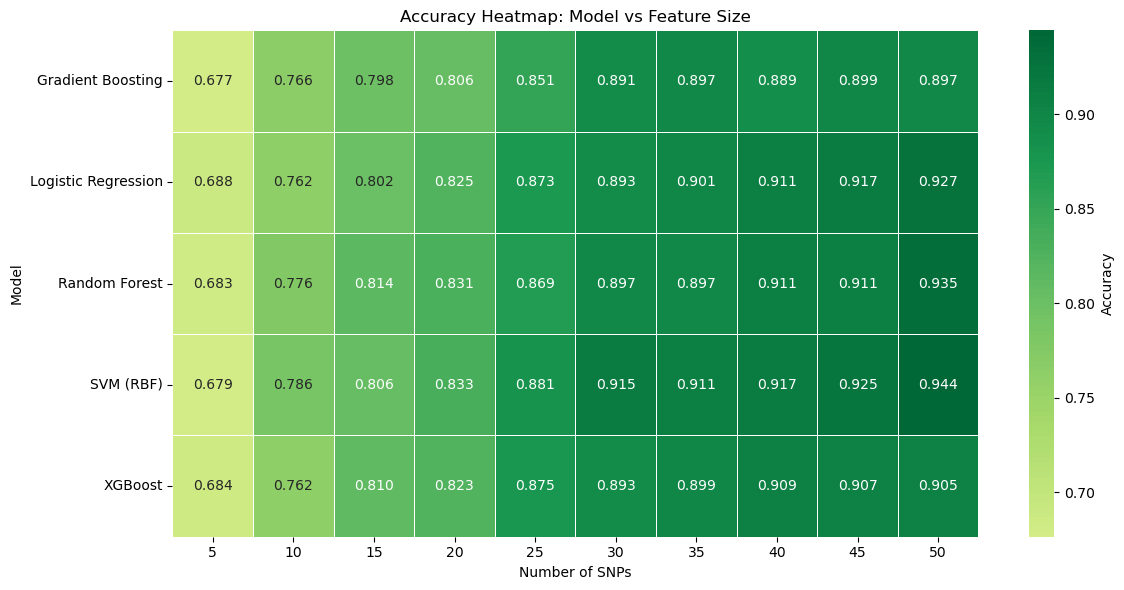

In [152]:
# Plot 2: Heatmap - Accuracy by Model and Feature Size
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.6,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('Accuracy Heatmap: Model vs Feature Size')
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Model')
plt.tight_layout()
plt.savefig(str(output_dir / 'feature_size_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

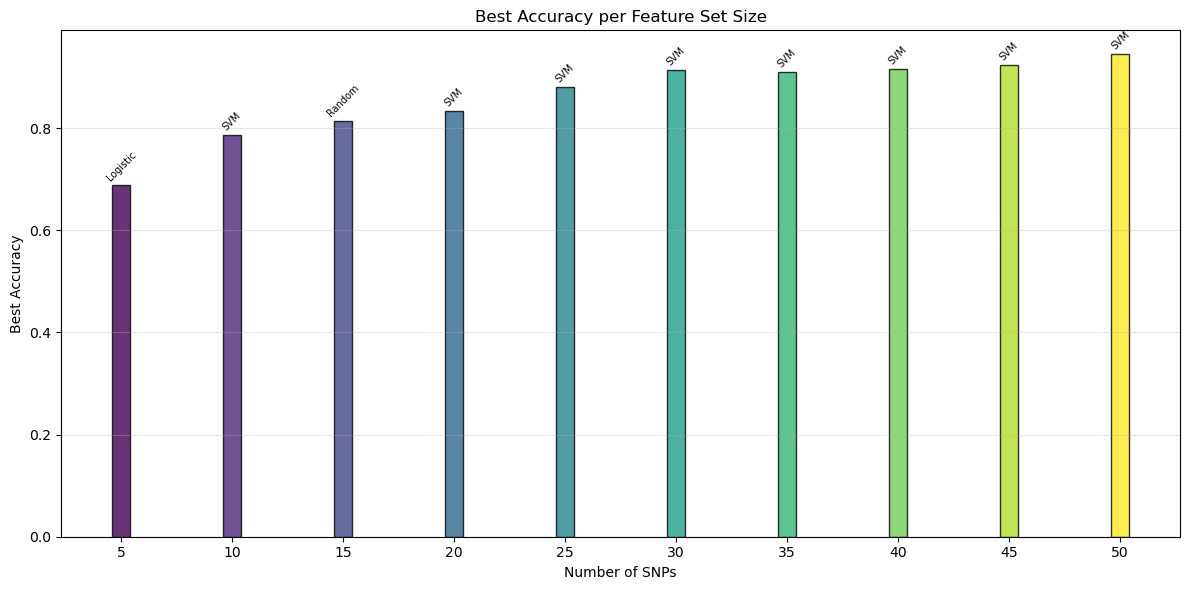


Best Model per Feature Size:
   5 SNPs: Logistic Regression  (0.6884 ± 0.0222)
  10 SNPs: SVM (RBF)            (0.7858 ± 0.0311)
  15 SNPs: Random Forest        (0.8135 ± 0.0381)
  20 SNPs: SVM (RBF)            (0.8333 ± 0.0254)
  25 SNPs: SVM (RBF)            (0.8809 ± 0.0421)
  30 SNPs: SVM (RBF)            (0.9146 ± 0.0314)
  35 SNPs: SVM (RBF)            (0.9106 ± 0.0329)
  40 SNPs: SVM (RBF)            (0.9167 ± 0.0270)
  45 SNPs: SVM (RBF)            (0.9246 ± 0.0240)
  50 SNPs: SVM (RBF)            (0.9445 ± 0.0204)

Results saved to: output/ml_models/sea_jpt_cn/feature_size_results.csv


In [153]:
# Plot 3: Best model per feature size
best_per_size = feature_size_df.loc[feature_size_df.groupby('N_Features')['Accuracy_Mean'].idxmax()]

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(best_per_size)))
bars = ax.bar(best_per_size['N_Features'], best_per_size['Accuracy_Mean'], 
              color=colors, edgecolor='black', alpha=0.8)
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Best Accuracy')
ax.set_title('Best Accuracy per Feature Set Size')
ax.set_xticks(feature_sizes)
ax.grid(True, alpha=0.3, axis='y')

# Add model names on bars
for bar, model in zip(bars, best_per_size['Model']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            model.split()[0], ha='center', va='bottom', fontsize=7, rotation=45)

plt.tight_layout()
plt.savefig(str(output_dir / 'feature_size_best_model.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\nBest Model per Feature Size:")
print("="*60)
for _, row in best_per_size.iterrows():
    print(f"  {int(row['N_Features']):2d} SNPs: {row['Model']:<20} ({row['Accuracy_Mean']:.4f} ± {row['Accuracy_Std']:.4f})")

# Save results
feature_size_df.to_csv(str(output_dir / 'feature_size_results.csv'), index=False)
pivot_df.to_csv(str(output_dir / 'feature_size_pivot.csv'))
print(f"\nResults saved to: {output_dir / 'feature_size_results.csv'}")

## Step 8c: TabPFN Evaluation on 25-50 Top SNPs

TabPFN is a transformer-based model optimized for small tabular datasets. Test it across feature sizes from 25 to 50 SNPs.

In [154]:
# TabPFN evaluation on 25-50 SNPs
if not SKIP_TRAINING and TABPFN_AVAILABLE:
    from tabpfn import TabPFNClassifier
    
    # Feature sizes for TabPFN (25 to 50)
    tabpfn_feature_sizes = [25, 30, 35, 40, 45, 50]
    tabpfn_feature_sizes = [s for s in tabpfn_feature_sizes if s <= max_features]
    
    tabpfn_results_list = []
    
    print("Testing TabPFN across feature sizes (25-50 SNPs)...")
    print("="*60)
    
    for n_features in tabpfn_feature_sizes:
        print(f"\n>>> TabPFN with {n_features} SNPs...")
        
        # Get top N features
        top_n_features = top_features_ordered[:n_features]
        X_reduced = X[top_n_features]
        
        # 5-Fold CV for TabPFN
        cv_scores_tabpfn = []
        
        for train_idx, val_idx in cv.split(X_reduced, y):
            try:
                tabpfn_cv = TabPFNClassifier(device='cpu', n_estimators=4)
                X_train_cv = X_reduced.values[train_idx]
                y_train_cv = y_encoded[train_idx]
                X_val_cv = X_reduced.values[val_idx]
                y_val_cv = y_encoded[val_idx]
                
                tabpfn_cv.fit(X_train_cv, y_train_cv)
                y_pred_cv = tabpfn_cv.predict(X_val_cv)
                
                from sklearn.metrics import accuracy_score
                cv_scores_tabpfn.append(accuracy_score(y_val_cv, y_pred_cv))
            except Exception as e:
                print(f"    Fold error: {e}")
                cv_scores_tabpfn.append(np.nan)
        
        mean_acc = np.nanmean(cv_scores_tabpfn)
        std_acc = np.nanstd(cv_scores_tabpfn)
        
        tabpfn_results_list.append({
            'N_Features': n_features,
            'Model': 'TabPFN',
            'Accuracy_Mean': mean_acc,
            'Accuracy_Std': std_acc
        })
        
        print(f"    Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    
    tabpfn_df = pd.DataFrame(tabpfn_results_list)
    print("\n" + "="*60)
    print("TabPFN testing complete!")
elif SKIP_TRAINING:
    # Load cached TabPFN results if available
    tabpfn_csv_path = output_dir / 'tabpfn_feature_size_results.csv'
    if tabpfn_csv_path.exists():
        tabpfn_df = pd.read_csv(tabpfn_csv_path)
        print("⏭️ Loaded cached TabPFN feature size results")
    else:
        tabpfn_df = pd.DataFrame()
        print("⏭️ Skipping TabPFN evaluation - no cached results available")
else:
    print("TabPFN not available. Install with: pip install tabpfn")
    tabpfn_df = pd.DataFrame()

TabPFN not available. Install with: pip install tabpfn


In [155]:
# Visualize TabPFN results and compare with other models
if not SKIP_TRAINING and TABPFN_AVAILABLE and len(tabpfn_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: TabPFN accuracy vs feature size
    ax = axes[0]
    ax.errorbar(tabpfn_df['N_Features'], tabpfn_df['Accuracy_Mean'], 
                yerr=tabpfn_df['Accuracy_Std'], fmt='o-', linewidth=2, 
                markersize=8, capsize=5, color='purple', label='TabPFN')
    ax.set_xlabel('Number of Top SNPs')
    ax.set_ylabel('Accuracy (5-Fold CV)')
    ax.set_title('TabPFN Performance vs Feature Set Size (25-50 SNPs)')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(tabpfn_feature_sizes)
    ax.legend()
    
    # Plot 2: Compare TabPFN with best other model at each size
    ax = axes[1]
    
    # Get best non-TabPFN model for sizes 25-50
    comparison_sizes = [s for s in tabpfn_feature_sizes if s in feature_sizes]
    best_other = feature_size_df[feature_size_df['N_Features'].isin(comparison_sizes)]
    best_other = best_other.loc[best_other.groupby('N_Features')['Accuracy_Mean'].idxmax()]
    
    x = np.arange(len(comparison_sizes))
    width = 0.35
    
    tabpfn_acc = tabpfn_df[tabpfn_df['N_Features'].isin(comparison_sizes)]['Accuracy_Mean'].values
    other_acc = best_other['Accuracy_Mean'].values
    other_models = best_other['Model'].values
    
    bars1 = ax.bar(x - width/2, tabpfn_acc, width, label='TabPFN', color='purple', alpha=0.8)
    bars2 = ax.bar(x + width/2, other_acc, width, label='Best Other Model', color='steelblue', alpha=0.8)
    
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Accuracy')
    ax.set_title('TabPFN vs Best Other Model (25-50 SNPs)')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_sizes)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add model names on bars
    for bar, model in zip(bars2, other_models):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                model.split()[0], ha='center', va='bottom', fontsize=7, rotation=45)
    
    plt.tight_layout()
    plt.savefig(str(output_dir / 'tabpfn_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print comparison summary
    print("\nTabPFN vs Best Other Model (25-50 SNPs):")
    print("="*70)
    print(f"{'N_SNPs':<10} {'TabPFN':<15} {'Best Other':<15} {'Model':<20}")
    print("-"*70)
    for i, n in enumerate(comparison_sizes):
        print(f"{n:<10} {tabpfn_acc[i]:<15.4f} {other_acc[i]:<15.4f} {other_models[i]:<20}")
    
    # Save TabPFN results
    tabpfn_df.to_csv(str(output_dir / 'tabpfn_feature_size_results.csv'), index=False)
    print(f"\nTabPFN results saved to: {output_dir / 'tabpfn_feature_size_results.csv'}")
else:
    print("⏭️ Skipping TabPFN visualization - using cached results or TabPFN not available")

⏭️ Skipping TabPFN visualization - using cached results or TabPFN not available


## Step 9: Save Models

In [156]:
# Create output directory and save models
if not SKIP_TRAINING:
    output_dir = ensure_dir(PATHS.ML_MODELS_DIR)

    # Save full feature models
    save_model(
        rf, output_dir / "random_forest_full.pkl",
        metadata={"n_features": len(feature_names), "accuracy": rf_results["accuracy"]},
    )

    save_model(
        lr, output_dir / "logistic_regression_full.pkl",
        metadata={"accuracy": lr_results["accuracy"]},
    )

    if xgb_clf is not None:
        save_model(
            xgb_clf, output_dir / "xgboost_full.pkl",
            metadata={"accuracy": xgb_results["accuracy"]},
        )

    # Save feature importance
    rf_importance.to_csv(output_dir / "feature_importances.csv", index=False)

    # Save top features list
    top_feature_df = rf_importance.head(ML.TOP_N_FEATURES)
    top_feature_df.to_csv(output_dir / f"top_{ML.TOP_N_FEATURES}_features.csv", index=False)

    # Save model comparison results from feature size testing
    # Get best result per model across all feature sizes
    best_per_model = feature_size_df.loc[feature_size_df.groupby('Model')['Accuracy_Mean'].idxmax()]
    comparison_results = best_per_model[['Model', 'Accuracy_Mean', 'Accuracy_Std', 'N_Features']].copy()
    comparison_results.columns = ['model', 'accuracy', 'accuracy_std', 'best_n_features']
    comparison_results = comparison_results.sort_values('accuracy', ascending=False)
    comparison_results.to_csv(output_dir / "model_comparison.csv", index=False)

    # Save TabPFN results if available
    if TABPFN_AVAILABLE and len(tabpfn_df) > 0:
        tabpfn_df.to_csv(output_dir / "tabpfn_feature_size_results.csv", index=False)

    print(f"\nAll models saved to: {output_dir}")
    print(f"\nFull Feature Models:")
    print(f"  - random_forest_full.pkl")
    print(f"  - logistic_regression_full.pkl")
    if xgb_clf is not None:
        print(f"  - xgboost_full.pkl")
    print(f"\nData Files:")
    print(f"  - feature_importances.csv")
    print(f"  - top_{ML.TOP_N_FEATURES}_features.csv")
    print(f"  - model_comparison.csv")
    print(f"  - feature_size_results.csv")
    if TABPFN_AVAILABLE and len(tabpfn_df) > 0:
        print(f"  - tabpfn_feature_size_results.csv")
else:
    print("⏭️ Skipping model saving - using cached results")

Model saved to: output/ml_models/sea_jpt_cn/random_forest_full.pkl
Model saved to: output/ml_models/sea_jpt_cn/logistic_regression_full.pkl
Model saved to: output/ml_models/sea_jpt_cn/xgboost_full.pkl

All models saved to: output/ml_models/sea_jpt_cn

Full Feature Models:
  - random_forest_full.pkl
  - logistic_regression_full.pkl
  - xgboost_full.pkl

Data Files:
  - feature_importances.csv
  - top_25_features.csv
  - model_comparison.csv
  - feature_size_results.csv


In [157]:
# Save Top 50 FST-only SNPs ML Data Matrix for Part 2 comparison
if not SKIP_TRAINING:
    TOP_50 = 50

    # Get top 50 SNP names from feature importance
    top_50_snps = rf_importance.head(TOP_50)['feature'].tolist()

    # Create ML data matrix with only top 50 SNPs
    # Load original ML data to get sample info
    import pandas as pd
    ml_data_full = pd.read_csv(ML_DATA_PATH)
    sample_ids = ml_data_full['sample']
    populations = ml_data_full['pop']

    # Get top 50 SNP columns
    top_50_snp_cols = [c for c in top_50_snps if c in ml_data_full.columns]
    print(f"Top 50 SNPs available in ML data: {len(top_50_snp_cols)}")

    # Create the top 50 ML data matrix
    fst_top50_df = ml_data_full[['sample', 'pop'] + top_50_snp_cols].copy()

    # Save to output directory
    fst_top50_path = output_dir / "fst_only_top50_ml_data.csv"
    fst_top50_df.to_csv(fst_top50_path, index=False)
    print(f"\nFST-only Top 50 ML data saved to: {fst_top50_path}")
    print(f"  Samples: {len(fst_top50_df)}")
    print(f"  SNPs: {len(top_50_snp_cols)}")

    # Also save top 50 SNP IDs for reference
    top50_ids_path = output_dir / "fst_only_top50_snp_ids.txt"
    with open(top50_ids_path, 'w') as f:
        for snp in top_50_snp_cols:
            f.write(f"{snp}\n")
    print(f"Top 50 SNP IDs saved to: {top50_ids_path}")

    # Save top 50 feature importance
    top50_importance_path = output_dir / "fst_only_top50_features.csv"
    rf_importance.head(TOP_50).to_csv(top50_importance_path, index=False)
    print(f"Top 50 feature importance saved to: {top50_importance_path}")
else:
    print("⏭️ Skipping Top 50 ML data saving - using cached results")

Top 50 SNPs available in ML data: 50

FST-only Top 50 ML data saved to: output/ml_models/sea_jpt_cn/fst_only_top50_ml_data.csv
  Samples: 504
  SNPs: 50
Top 50 SNP IDs saved to: output/ml_models/sea_jpt_cn/fst_only_top50_snp_ids.txt
Top 50 feature importance saved to: output/ml_models/sea_jpt_cn/fst_only_top50_features.csv


## Summary

In [159]:
# Summary of training results
print("="*70)
print("ML TRAINING SUMMARY")
print("="*70)
if SKIP_TRAINING:
    print("\n⏭️ SKIP_TRAINING MODE: Using cached results")

print(f"\nData:")
print(f"  Total Samples: {len(X)}")
print(f"  Total Features: {len(feature_names)}")
print(f"  Classes: {len(le.classes_)} ({list(le.classes_)})")

# Find best model from feature size testing
best_per_model = feature_size_df.loc[feature_size_df.groupby('Model')['Accuracy_Mean'].idxmax()]
best_per_model_sorted = best_per_model.sort_values('Accuracy_Mean', ascending=False)
best_overall = best_per_model_sorted.iloc[0]

print(f"\n🏆 Best Model: {best_overall['Model']}")
print(f"   Best N_Features: {int(best_overall['N_Features'])}")
print(f"   Accuracy: {best_overall['Accuracy_Mean']:.4f} ± {best_overall['Accuracy_Std']:.4f}")

print(f"\nModel Rankings (best feature size per model):")
print("-"*70)
for rank, (_, row) in enumerate(best_per_model_sorted.iterrows(), 1):
    print(f"  {rank}. {row['Model']:<25} {row['Accuracy_Mean']:.4f} (at {int(row['N_Features'])} SNPs)")

print(f"\nOutput directory: {output_dir}")
print(f"\nNext step: Run 05_model_evaluation.ipynb for detailed analysis")

ML TRAINING SUMMARY

Data:
  Total Samples: 504
  Total Features: 2518
  Classes: 3 (['CN', 'JPT', 'SEA'])

🏆 Best Model: SVM (RBF)
   Best N_Features: 50
   Accuracy: 0.9445 ± 0.0204

Model Rankings (best feature size per model):
----------------------------------------------------------------------
  1. SVM (RBF)                 0.9445 (at 50 SNPs)
  2. Random Forest             0.9345 (at 50 SNPs)
  3. Logistic Regression       0.9266 (at 50 SNPs)
  4. XGBoost                   0.9086 (at 40 SNPs)
  5. Gradient Boosting         0.8987 (at 45 SNPs)

Output directory: output/ml_models/sea_jpt_cn

Next step: Run 05_model_evaluation.ipynb for detailed analysis
